# 1. Libraries

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

import datetime

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import linear_model

from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import uniform

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# 2. Data

## 2.1 Load Raw Data

In [3]:
start_sp = datetime.datetime(1900, 1, 1)
end_sp = datetime.datetime(2018, 12, 31)

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)

[*********************100%***********************]  1 of 1 downloaded


## 2.2 Features

In [4]:
# Compute the logarithmic returns using the Closing price 
sp500['Log_Ret_1d'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

# Compute logarithmic returns using the pandas rolling mean function
sp500['Log_Ret_1w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=5).sum()
sp500['Log_Ret_2w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=10).sum()
sp500['Log_Ret_3w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=15).sum()
sp500['Log_Ret_4w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=20).sum()
sp500['Log_Ret_8w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=40).sum()
sp500['Log_Ret_12w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=60).sum()
sp500['Log_Ret_16w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=80).sum()
sp500['Log_Ret_20w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=100).sum()
sp500['Log_Ret_24w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=120).sum()
sp500['Log_Ret_28w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=140).sum()
sp500['Log_Ret_32w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=160).sum()
sp500['Log_Ret_36w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=180).sum()
sp500['Log_Ret_40w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=200).sum()
sp500['Log_Ret_44w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=220).sum()
sp500['Log_Ret_48w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=240).sum()
sp500['Log_Ret_52w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=260).sum()
sp500['Log_Ret_56w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=280).sum()
sp500['Log_Ret_60w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=300).sum()
sp500['Log_Ret_64w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=320).sum()
sp500['Log_Ret_68w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=340).sum()
sp500['Log_Ret_72w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=360).sum()
sp500['Log_Ret_76w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=380).sum()
sp500['Log_Ret_80w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=400).sum()


# Compute Volatility using the pandas rolling standard deviation function
sp500['Vol_1w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
sp500['Vol_2w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=10).std()*np.sqrt(10)
sp500['Vol_3w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=15).std()*np.sqrt(15)
sp500['Vol_4w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=20).std()*np.sqrt(20)
sp500['Vol_8w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=40).std()*np.sqrt(40)
sp500['Vol_12w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=60).std()*np.sqrt(60)
sp500['Vol_16w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=80).std()*np.sqrt(80)
sp500['Vol_20w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=100).std()*np.sqrt(100)
sp500['Vol_24w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=120).std()*np.sqrt(120)
sp500['Vol_28w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=140).std()*np.sqrt(140)
sp500['Vol_32w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=160).std()*np.sqrt(160)
sp500['Vol_36w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=180).std()*np.sqrt(180)
sp500['Vol_40w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=200).std()*np.sqrt(200)
sp500['Vol_44w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=220).std()*np.sqrt(220)
sp500['Vol_48w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=240).std()*np.sqrt(240)
sp500['Vol_52w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=260).std()*np.sqrt(260)
sp500['Vol_56w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=280).std()*np.sqrt(280)
sp500['Vol_60w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=300).std()*np.sqrt(300)
sp500['Vol_64w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=320).std()*np.sqrt(320)
sp500['Vol_68w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=340).std()*np.sqrt(340)
sp500['Vol_72w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=360).std()*np.sqrt(360)
sp500['Vol_76w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=380).std()*np.sqrt(380)
sp500['Vol_80w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

# Compute Volumes using the pandas rolling mean function
sp500['Volume_1w'] = pd.Series(sp500['Volume']).rolling(window=5).mean()
sp500['Volume_2w'] = pd.Series(sp500['Volume']).rolling(window=10).mean()
sp500['Volume_3w'] = pd.Series(sp500['Volume']).rolling(window=15).mean()
sp500['Volume_4w'] = pd.Series(sp500['Volume']).rolling(window=20).mean()
sp500['Volume_8w'] = pd.Series(sp500['Volume']).rolling(window=40).mean()
sp500['Volume_12w'] = pd.Series(sp500['Volume']).rolling(window=60).mean()
sp500['Volume_16w'] = pd.Series(sp500['Volume']).rolling(window=80).mean()
sp500['Volume_20w'] = pd.Series(sp500['Volume']).rolling(window=100).mean()
sp500['Volume_24w'] = pd.Series(sp500['Volume']).rolling(window=120).mean()
sp500['Volume_28w'] = pd.Series(sp500['Volume']).rolling(window=140).mean()
sp500['Volume_32w'] = pd.Series(sp500['Volume']).rolling(window=160).mean()
sp500['Volume_36w'] = pd.Series(sp500['Volume']).rolling(window=180).mean()
sp500['Volume_40w'] = pd.Series(sp500['Volume']).rolling(window=200).mean()
sp500['Volume_44w'] = pd.Series(sp500['Volume']).rolling(window=220).mean()
sp500['Volume_48w'] = pd.Series(sp500['Volume']).rolling(window=240).mean()
sp500['Volume_52w'] = pd.Series(sp500['Volume']).rolling(window=260).mean()
sp500['Volume_56w'] = pd.Series(sp500['Volume']).rolling(window=280).mean()
sp500['Volume_60w'] = pd.Series(sp500['Volume']).rolling(window=300).mean()
sp500['Volume_64w'] = pd.Series(sp500['Volume']).rolling(window=320).mean()
sp500['Volume_68w'] = pd.Series(sp500['Volume']).rolling(window=340).mean()
sp500['Volume_72w'] = pd.Series(sp500['Volume']).rolling(window=360).mean()
sp500['Volume_76w'] = pd.Series(sp500['Volume']).rolling(window=380).mean()
sp500['Volume_80w'] = pd.Series(sp500['Volume']).rolling(window=400).mean()

# Drop NA´s
sp500 = sp500.dropna("index")

# Label data: Up (Down) if the the 1 month (≈ 20 trading days) logarithmic return increased (decreased)
sp500['Label'] = np.where(pd.Series(sp500['Log_Ret_1d']).rolling(window=21).sum() > 0, 1, 0)

## 2.3 Basic Information 

In [5]:
# Show rows and columns
print("Rows, Columns:");print(sp500.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(sp500.columns);print("\n")

# Show info on DataFrame
print("Info:");print(sp500.info()); print("\n")

# Count Non-NA values
print("Non-NA:");print(sp500.count()); print("\n")

# Show head
print("Head");print(sp500.head()); print("\n")

# Show tail
print("Tail");print(sp500.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(sp500.describe());print("\n")

Rows, Columns:
(16960, 77)


Columns:
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log_Ret_1d',
       'Log_Ret_1w', 'Log_Ret_2w', 'Log_Ret_3w', 'Log_Ret_4w', 'Log_Ret_8w',
       'Log_Ret_12w', 'Log_Ret_16w', 'Log_Ret_20w', 'Log_Ret_24w',
       'Log_Ret_28w', 'Log_Ret_32w', 'Log_Ret_36w', 'Log_Ret_40w',
       'Log_Ret_44w', 'Log_Ret_48w', 'Log_Ret_52w', 'Log_Ret_56w',
       'Log_Ret_60w', 'Log_Ret_64w', 'Log_Ret_68w', 'Log_Ret_72w',
       'Log_Ret_76w', 'Log_Ret_80w', 'Vol_1w', 'Vol_2w', 'Vol_3w', 'Vol_4w',
       'Vol_8w', 'Vol_12w', 'Vol_16w', 'Vol_20w', 'Vol_24w', 'Vol_28w',
       'Vol_32w', 'Vol_36w', 'Vol_40w', 'Vol_44w', 'Vol_48w', 'Vol_52w',
       'Vol_56w', 'Vol_60w', 'Vol_64w', 'Vol_68w', 'Vol_72w', 'Vol_76w',
       'Vol_80w', 'Volume_1w', 'Volume_2w', 'Volume_3w', 'Volume_4w',
       'Volume_8w', 'Volume_12w', 'Volume_16w', 'Volume_20w', 'Volume_24w',
       'Volume_28w', 'Volume_32w', 'Volume_36w', 'Volume_40w', 'Volume_44w',
       'Volume_48w', 'V

               Open          High           Low         Close     Adj Close  \
count  16960.000000  16960.000000  16960.000000  16960.000000  16960.000000   
mean     581.501505    584.943686    577.845423    581.612876    581.612876   
std      678.796967    682.250255    675.002328    678.842598    678.842598   
min       22.400000     22.400000     22.400000     22.400000     22.400000   
25%       88.419998     89.217500     87.690002     88.430000     88.430000   
50%      182.055001    182.719993    181.264999    182.070000    182.070000   
75%     1104.302490   1111.099976   1095.882507   1104.302490   1104.302490   
max     2936.760010   2940.909912   2927.110107   2930.750000   2930.750000   

             Volume    Log_Ret_1d    Log_Ret_1w    Log_Ret_2w    Log_Ret_3w  \
count  1.696000e+04  16960.000000  16960.000000  16960.000000  16960.000000   
mean   9.423259e+08      0.000276      0.001377      0.002770      0.004181   
std    1.559454e+09      0.009683      0.021542    

## 2.4 Plot data

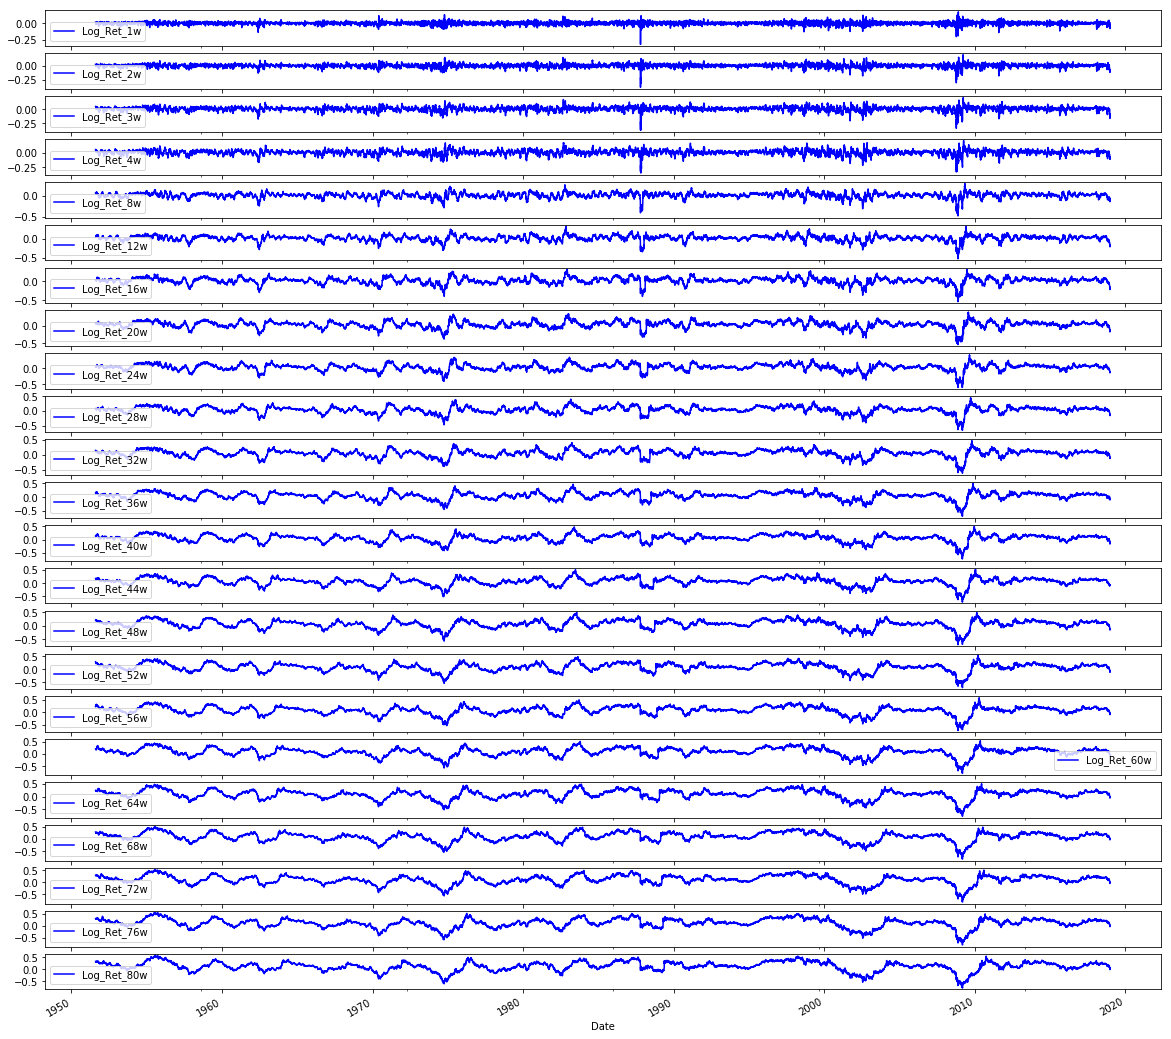

In [6]:
# Plot the logarithmic returns
sp500.iloc[:,7:30].plot(subplots=True, color='blue',figsize=(20, 20));

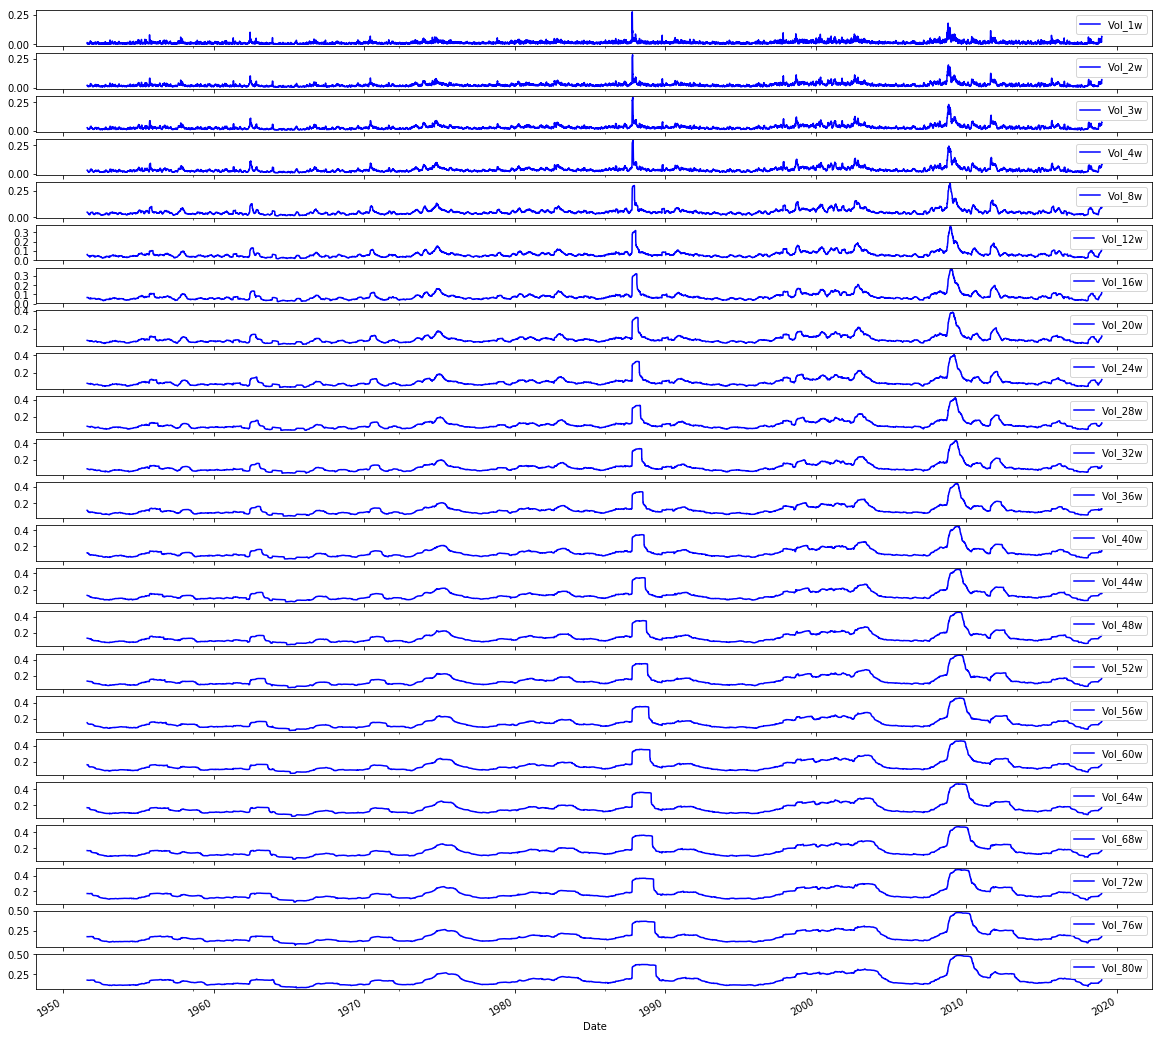

In [7]:
# Plot the Volatilities
sp500.iloc[:,30:53].plot(subplots=True, color='blue',figsize=(20, 20));

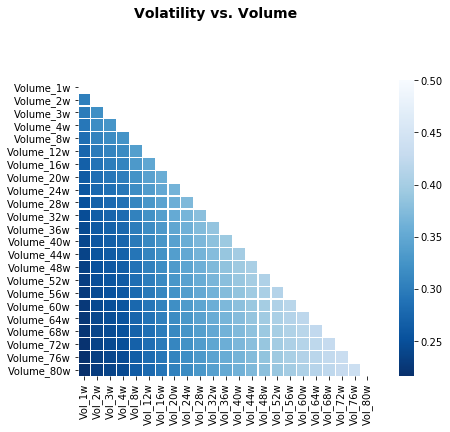

In [8]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,30:53].columns 

corr = sp500.iloc[:,30:76].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold');

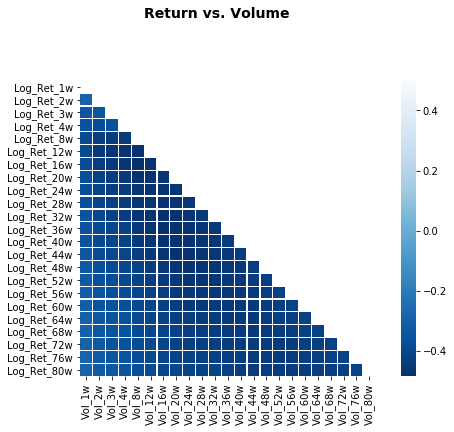

In [9]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,30:53].columns 

corr = sp500.iloc[:,7:53].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Return vs. Volume', fontsize=14, fontweight='bold');

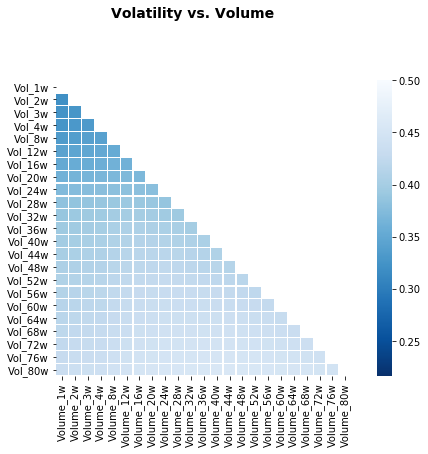

In [10]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,53:76].columns 

corr = sp500.iloc[:, np.r_[30:53, 53:76]].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold');

## 2.5 Scaling

In [11]:
# Get column names of the features
names_features = sp500.iloc[:,7:76].columns

### 2.5.1 Standardization

In [12]:
# standardize the feature attributes

# Create the Scaler object
scaler_standardized = preprocessing.StandardScaler()

# Fit data on the scaler object
scaled_features_standardized = scaler_standardized.fit_transform(sp500.iloc[:,7:76])
scaled_features_standardized = pd.DataFrame(scaled_features_standardized, columns=names_features, index=sp500.index)

# Concatenate DataFrames
sp500_standardized = pd.concat([sp500.iloc[:,:7], scaled_features_standardized, sp500.iloc[:,76:77]], axis=1)

### 2.5.2 Normalization

In [13]:
# Normalize the feature attributes

# Create the Scaler object
scaler_normalize = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Fit data on the scaler object
scaled_features_normalized = scaler_normalize.fit_transform(sp500.iloc[:,7:76])
scaled_features_normalized = pd.DataFrame(scaled_features_normalized, columns=names_features, index=sp500.index)

# Concatenate DataFrames
sp500_normalized = pd.concat([sp500.iloc[:,:7], scaled_features_normalized, sp500.iloc[:,76:77]], axis=1)

## 2.6 Separating Test Data

### 2.6.1 Non-Scaled Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(sp500.iloc[:,7:76], sp500.iloc[:,76], test_size=0.01 ,shuffle = False, stratify = None)

### 2.6.2 Standardized Data

In [15]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(sp500_standardized.iloc[:,7:76], sp500_standardized.iloc[:,76], test_size=0.1,shuffle = False, stratify = None)

### 2.6.3 Normalized Data

In [16]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(sp500_normalized.iloc[:,7:76], sp500_normalized.iloc[:,76], test_size=0.1,shuffle = False, stratify = None)

## 2.7 Label Distribution

In [17]:
print("train set increase bias = "+ str(np.mean(y_train==1))+"%")

print("test set increase bias = " + str(np.mean(y_test==1))+"%")

train set increase bias = 0.6068493150684932%
test set increase bias = 0.6647058823529411%


# 3. Models

## 3.1 Baseline Model Development

In [18]:
# Instantiate the model
logistic = linear_model.SGDClassifier(random_state=1, tol=None, shuffle=False, early_stopping=False)

# Create loss function
loss = ["log"]

# Time Series Split 
tscv = TimeSeriesSplit(n_splits=10) 

# Evaluation Metric
metric = 'Accuracy'

# Multi-metric evaluation
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}



#Hyperparameter

# Number of iterations
iterations = [7] 
penalty = ['l1', 'l2', 'elasticnet']


## Grid Search

# Create regularization hyperparameter 
#alpha_g = [ 0.001, 0.01, 0.1, 1]
#l1_ratio_g = [0.2, 0.4, 0.6, 0.8]

# Create hyperparameter options
#hyperparameters_g = dict(alpha=alpha_g, l1_ratio=l1_ratio_g, penalty=penalty, loss=loss, max_iter=iterations)


# Create grid search 
#search_g = GridSearchCV(logistic, param_grid=hyperparameters_g, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring, refit=metric, return_train_score=True)
# Setting refit='AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score.

# Fit grid search
#tuned_model = search_g.fit(X_train, y_train)


## Random Search

# Create regularization hyperparameter distribution using uniform distribution
alpha_r = uniform(loc=0.1, scale=0.7) 
l1_ratio_r = uniform(loc=0, scale=1) 

# Create hyperparameter options
hyperparameters_r = dict(alpha=alpha_r, l1_ratio=l1_ratio_r, penalty=penalty, loss=loss, max_iter=iterations)



# Create randomized search 
search_r = RandomizedSearchCV(logistic, hyperparameters_r, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring, refit = metric, return_train_score=True)

# Fit randomized search
tuned_model = search_r.fit(X_train, y_train)



# View Cost function
print('Loss function:', tuned_model.best_estimator_.get_params()['loss'])

# View Accuracy 
print(metric +' of the best model: ', tuned_model.best_score_);print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model.best_estimator_.get_params()['max_iter'])
print('Penalty:', tuned_model.best_estimator_.get_params()['penalty'])
print('Alpha:', tuned_model.best_estimator_.get_params()['alpha'])
print('l1_ratio:', tuned_model.best_estimator_.get_params()['l1_ratio'])

Loss function: log
Accuracy of the best model:  0.5645478374836173


Best hyperparameters:
Number of iterations: 7
Penalty: l1
Alpha: 0.5846258309685198
l1_ratio: 0.8763891522960383


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


## 3.2 Time Series Split

Time Series cross-validator provides train/dev indices to split time series data samples that are observed at fixed time intervals, in train/dev sets. In each split, dev indices must be higher than before, and thus shuffling in cross validator is inappropriate. The following graph illustrates how the time series split works:


<img src="split.png" width="400" />






## 3.3 Regularization

Regularization adds a penalty on the different parameters of the model to reduce the freedom of the model. Hence, the model will be less likely to fit the noise of the training data and will improve the generalization abilities of the mode


### 3.3.1 L2 Regularization (Ridge penalisation)

The L2 regularization adds a penalty equal to the sum of the squared value of the coefficients.

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m\beta_{i}^2\tag{1}$$

The λ parameter is a scalar that should be learned as well, using cross validation.


The L2 regularization will force the **parameters to be relatively small**, the bigger the penalization, the smaller (and the more robust) the coefficients are.

<img src="ridge.png" width="500" />






### 3.3.2 L1 Regularization (Lasso penalisation)

The L1 regularization adds a penalty equal to the sum of the absolute value of the coefficients. 

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m|\beta_{i}|\tag{2}$$

The λ parameter is a scalar that should be learned as well, using cross validation.

The L1 regularization will **shrink some parameters to zero**. Hence some variables will not play any role in the model, L1 regression can be seen as a way to select features in a model. 


<img src="lasso.png" width="500" />


### 3.3.3 Elastic Net 

Elastic-net is a **mix of both L1 and L2 regularizations**. A penalty is applied to the sum of the absolute values and to the sum of the squared values:

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda((1-\alpha)\sum_{i=1}^m\beta{i}^2+\alpha\sum_{i=1}^m|\beta_{i}|)\tag{3}$$ 

Lambda is a shared penalization parameter while alpha sets the ratio between L1 and L2 regularization in the Elastic Net Regularization. Hence, we expect a hybrid behavior between L1 and L2 regularization.

Though coefficients are cut, the cut is less abrupt than the cut with lasso penalization alone. 

In [19]:
# Find the number of nonzero coefficients (selected features)
best_lr = tuned_model.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Total number of features: 69
Number of selected features: 23


## 3.4 Model Evaluation 

### 3.4.1 Confusion Matrix



Accuracy: 0.5823529411764706
Precision: 0.675
Recall: 0.7168141592920354


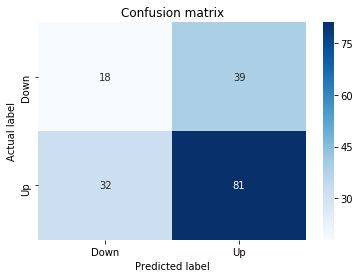

In [20]:
# Make predictions
y_pred = tuned_model.predict(X_test)

# create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### 3.4.2 ROC Curve

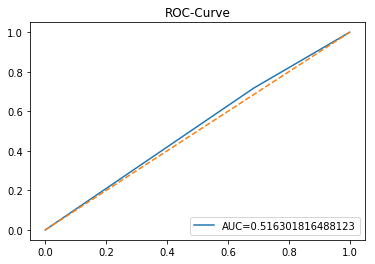

In [21]:
y_pred_proba= tuned_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC-Curve')
plt.show()